## Kaiser–Bessel Function
The Kaiser–Bessel kernel is defined as:

$$K(x) = \frac{I_0(\beta \sqrt{1 - \left(\frac{2x}{W}\right)^2})}{I_0(\beta)}$$

where:
- $x$ is the input coordinate (typically $x \in [0, 1]$ for normalized domain)
- $W = w \cdot \sigma$ is the kernel support width
- $w$ is the kernel width parameter (default: 16)
- $\sigma$ is the oversampling factor (default: 2)
- $\beta = \pi w \left(1 - \frac{1}{2\sigma}\right)$ is the shape parameter
- $I_0(z)$ is the modified Bessel function of the first kind, order 0

## Modified Bessel Function $I_0(z)$
The modified Bessel function of the first kind, order 0, can be computed using:

**For small arguments** ($|z| \leq 15$):
$$I_0(z) = \sum_{k=0}^{\infty} \frac{1}{(k!)^2} \left(\frac{z^2}{4}\right)^k$$

**For large arguments** ($|z| > 15$):
$$I_0(z) \approx \frac{e^{|z|}}{\sqrt{2\pi |z|}} \sum_{k=0}^{\infty} \frac{(-1)^k (2k-1)!!^2}{k! (8|z|)^k}$$

## Domain and Properties
- Input domain: $x \in [0, 1]$ (normalized)  
- The kernel is symmetric: $K(-x) = K(x)$
- Maximum value at $x = 0$: $K(0) = 1$
- Approaches zero as $|x| \to 1$

In [1]:
# Disable parallelism in NumPy and other libraries to ensure single-threaded execution
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

print("Parallelism disabled: All libraries set to use 1 thread")

Parallelism disabled: All libraries set to use 1 thread


In [2]:
# --- Setup ---
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numba
import cppyy
from numpy.polynomial import Chebyshev as Ch
import scipy

from baobzi import Baobzi

# Global parameters
w = 1.5
sigma = 2.0
W = w * sigma
a, b = 0.0, 1.0   # domain for plotting and benchmarking

# Benchmark size
N = 100_000

# Reproducibility
rng = np.random.default_rng(42)
dx_bench = rng.uniform(a, b, size=N)  # fixed samples for fair comparisons

# Plot grid, Baobzi fits on open interval so this avoids a crash
dx_plot = np.linspace(a, b, 1000, endpoint=False)

In [3]:
# --- Utilities ---

def benchmark_func(func, name, elems, warmup=None):
    """
    func: callable (scalar function)
    name: str
    elems: iterable of scalars
    warmup: optional callable to warm up JITs (e.g., numba) before timing.
    """
    if warmup is not None:
        warmup()

    t0 = time.perf_counter()
    # Always use list comprehension for scalar evaluation
    y = [func(x) for x in elems]
    t1 = time.perf_counter()

    N = len(elems)
    total_time = t1 - t0
    return {
        "method": name,
        "N": N,
        "seconds": total_time,
        "M evals/s": (N / total_time) / 1e6,
        "checksum": float(np.sum(y))
    }


def add_relative_speedup(df, baseline="numpy"):
    df = df.copy()
    # throughput proportional to "M evals/s"
    base = df.loc[df["method"] == baseline, "M evals/s"]
    if len(base) == 0:
        df["speedup_vs_numpy"] = np.nan
        return df
    base = float(base.iloc[0])
    df["speedup_vs_numpy"] = df["M evals/s"] / base
    return df


def plot_overlay(curves, title="Kaiser–Bessel kernel", xlabel="dx", ylabel="value"):
    plt.figure()
    for y, label in curves:
        plt.plot(dx_plot, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title + f" (w={w:.1f}, sigma={sigma:.1f})")
    plt.legend()
    plt.show()

## Method 1: NumPy (plain, scalar)
Scalar implementation using `numpy` operations and `np.i0`.

In [4]:
# Method 1: NumPy (scalar only)
def kaiser_bessel_numpy(dx):
    """
    Scalar Kaiser-Bessel function using NumPy functions.
    dx: scalar value
    Uses global parameters w and sigma.
    """
    W = w * sigma
    a = (2.0 * dx) / W
    beta = np.pi * w * (1.0 - 1.0 / (2.0 * sigma))
    # clamp the inner sqrt to avoid negative due to fp error
    inside = 1.0 - a*a
    inside = max(0.0, inside)
    t = np.sqrt(inside)
    return float(np.i0(beta * t) / np.i0(beta))

## Plot: Method 1

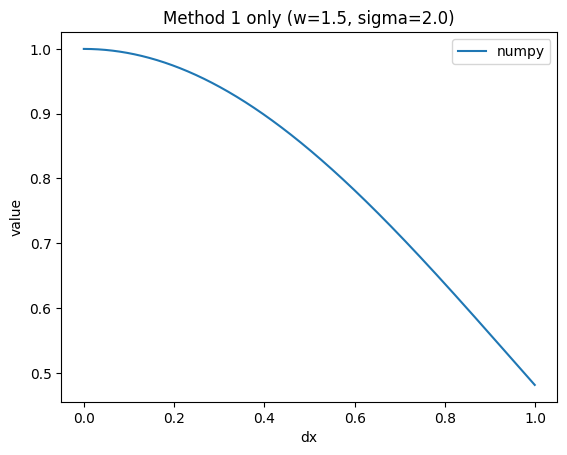

In [5]:
# Use list comprehension for scalar evaluation
y1 = [kaiser_bessel_numpy(x) for x in dx_plot]
plot_overlay([(y1, "numpy")], title="Method 1 only")

## Benchmark: Method 1

In [6]:
results = []
results.append(benchmark_func(lambda x: kaiser_bessel_numpy(x),
                              "numpy", dx_bench))
df = pd.DataFrame(results)
display(df)

,method,N,seconds,M evals/s,checksum
0,numpy,100000,9.363887,0.010679,80855.205152


## Method 2: C++ via `cppyy`

Scalar implementation using C++ code compiled at runtime via cppyy.
Uses the standard library's modified Bessel function.

In [7]:
cppyy.cppdef(r'''
#pragma GCC optimize ("O3")
#pragma GCC target("native")

#include <cmath>

inline double kaiser_bessel(double dx, double w, double sigma) {
    const double W = w * sigma;
    const double a = (2.0 * dx) / W;
    constexpr double pi = 3.14159265358979323846;
    const double beta = pi * w * (1.0 - 1.0 / (2.0 * sigma));
    const double inside = 1.0 - a * a;
    const double t = std::sqrt(inside);
    return std::cyl_bessel_i(0.0, beta * t) / std::cyl_bessel_i(0.0, beta);
}
''')

def kaiser_bessel_cpp(x):
    """
    Scalar Kaiser-Bessel function using C++ via cppyy.
    x: scalar value
    Uses global parameters w and sigma.
    """
    return float(cppyy.gbl.kaiser_bessel(float(x), float(w), float(sigma)))

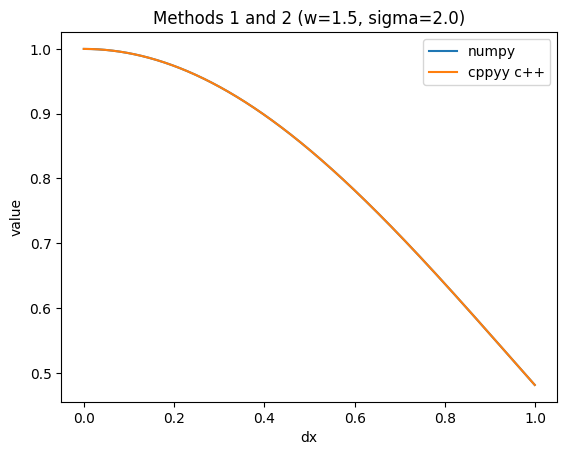

In [8]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
plot_overlay(curves, title="Methods 1 and 2")

In [9]:
# Accumulate results
results.append(benchmark_func(lambda x: kaiser_bessel_cpp(x),
                                "cppyy c++", dx_bench))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,9.363887,0.010679,80855.205152,1.000000
1,cppyy c++,100000,0.081539,1.226400,80855.205152,114.838703


## Method 3: `@numba.njit`
Scalar `i0` and kernel using Numba JIT compilation for performance.
If Numba is unavailable, this section will skip.

In [10]:
@numba.njit
def kaiser_bessel_jit(dx, w_val, sigma_val):
    """
    Scalar Kaiser-Bessel function using Numba JIT with direct C++ Bessel function integration.
    dx: scalar value
    w_val, sigma_val: parameters passed from global values
    """
    W = w_val * sigma_val
    a = (2.0 * dx) / W
    beta = math.pi * w_val * (1.0 - 1.0 / (2.0 * sigma_val))
    inside = 1.0 - a * a
    if inside < 0.0:
        inside = 0.0
    t = math.sqrt(inside)
    
    # Direct call to C++ function - cppyy.numba_ext makes this work seamlessly!
    return np.i0(beta * t) / np.i0(beta)

def _numba_warmup():
    # warm up compilation
    _ = kaiser_bessel_jit(0.0, w, sigma)
    _ = kaiser_bessel_jit(0.5, w, sigma)
    _ = kaiser_bessel_jit(1.0, w, sigma)
print("Numba + C++ integration ready!")


Numba + C++ integration ready!


In [11]:
try:
    _numba_warmup()

except Exception as e:
    print("NUMBA compilation failed!")
    print(e)

NUMBA compilation failed!
Failed in nopython mode pipeline (step: nopython frontend)
Use of unsupported NumPy function 'numpy.i0' or unsupported use of the function.

File "../../../../../tmp/ipykernel_289022/1896978236.py", line 17:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_289022/1896978236.py (17)

File "../../../../../tmp/ipykernel_289022/1896978236.py", line 17:
<source missing, REPL/exec in use?>

During: Pass nopython_type_inference


In [12]:
# Import cppyy numba extension for seamless integration
import cppyy.numba_ext

# Define C++ Bessel function using cppyy
cppyy.cppdef(r'''
#include <cmath>
double i0(double x) {
    return std::cyl_bessel_i(0.0, x);
}
''')

@numba.njit
def kaiser_bessel_jit(dx, w_val, sigma_val):
    """
    Scalar Kaiser-Bessel function using Numba JIT with direct C++ Bessel function integration.
    dx: scalar value
    w_val, sigma_val: parameters passed from global values
    """
    W = w_val * sigma_val
    a = (2.0 * dx) / W
    beta = math.pi * w_val * (1.0 - 1.0 / (2.0 * sigma_val))
    inside = 1.0 - a * a
    if inside < 0.0:
        inside = 0.0
    t = math.sqrt(inside)

    # Direct call to C++ function - cppyy.numba_ext makes this work seamlessly!
    return cppyy.gbl.i0(beta * t) / cppyy.gbl.i0(beta)

def _numba_warmup():
    # warm up compilation
    _ = kaiser_bessel_jit(0.0, w, sigma)
    _ = kaiser_bessel_jit(0.5, w, sigma)
    _ = kaiser_bessel_jit(1.0, w, sigma)

print("Numba + C++ integration ready!")
_numba_warmup()

Numba + C++ integration ready!


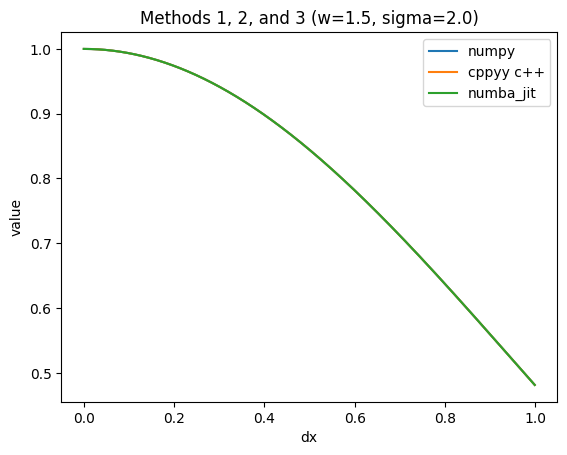

In [13]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))

plot_overlay(curves, title="Methods 1, 2, and 3")

In [14]:
results.append(benchmark_func(lambda x: kaiser_bessel_jit(x, w, sigma),
                                "numba_jit", dx_bench, warmup=_numba_warmup))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,9.363887,0.010679,80855.205152,1.000000
1,cppyy c++,100000,0.081539,1.226400,80855.205152,114.838703
2,numba_jit,100000,0.100530,0.994723,80855.205152,93.144750


## Method 4: NumPy Chebyshev fit
Chebyshev fit on `[0, 1]` with degree 16

In [15]:
def kaiser_bessel_poly(deg=16, samples=4097, domain=(0.0, 1.0)):
    """
    Fit Chebyshev polynomial to kaiser_bessel on [domain[0], domain[1]].
    Returns a numpy.polynomial.Chebyshev object that can be called on scalars.
    Uses global parameters w and sigma.
    """
    x = np.linspace(domain[0], domain[1], samples)
    y = [kaiser_bessel_numpy(xi) for xi in x]
    return Ch.fit(x, y, deg, domain=domain)

np_cheb = kaiser_bessel_poly(deg=16, samples=4096, domain=(0.0, 1.0))

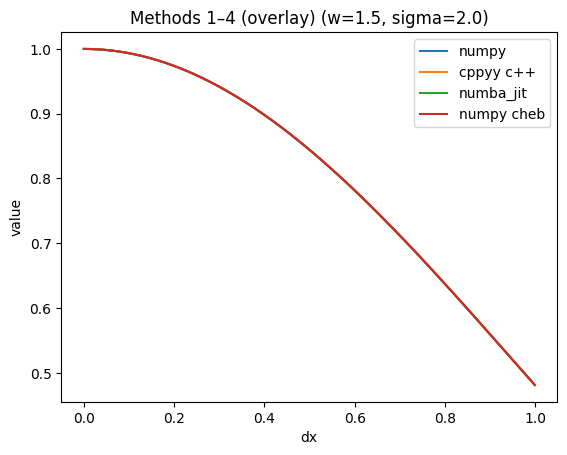

In [16]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))

y4 = [np_cheb(x) for x in dx_plot]
curves.append((y4, "numpy cheb"))

plot_overlay(curves, title="Methods 1–4 (overlay)")

In [17]:
results.append(benchmark_func(lambda x: np_cheb(x),
                              "numpy cheb", dx_bench))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,9.363887,0.010679,80855.205152,1.000000
1,cppyy c++,100000,0.081539,1.226400,80855.205152,114.838703
2,numba_jit,100000,0.100530,0.994723,80855.205152,93.144750
3,numpy cheb,100000,0.446331,0.224049,80855.205152,20.979681


## Method 5: C++ Chebyshev via `cppyy`
Uses a simple Chebyshev class in C++ that maps `[0, 1]` to `[-1, 1]` internally.
If `cppyy` is not installed, this section will skip.

In [18]:
cppyy.cppdef(r'''
#pragma GCC optimize ("O3", "unroll-loops")
#pragma GCC target("native")

#include <vector>
#include <algorithm>
#include <functional>
#include <cmath>
#include <type_traits>
#include <cstddef>

#define ALWAYS_INLINE inline __attribute__((always_inline))

using InputType = double;

constexpr double PI = 3.14159265358979323846;

template <class Func> class Cheb {
public:
    Cheb(Func F, const int n, const InputType a = -1, const InputType b = 1)
        : nodes(n), low(InputType(1) / (b - a)), hi(b + a), coeffs(nodes) {

        std::vector<double> fvals(nodes);

        for (int k = 0; k < nodes; ++k) {
            double theta = (2 * k + 1) * PI / (2 * nodes);
            double xk = std::cos(theta);
            double x_mapped = map_to_domain(xk);
            fvals[k] = F(x_mapped);
        }

        for (int m = 0; m < nodes; ++m) {
            double sum = 0.0;
            for (int k = 0; k < nodes; ++k) {
                double theta = (2 * k + 1) * PI / (2 * nodes);
                sum += fvals[k] * std::cos(m * theta);
            }
            coeffs[m] = (2.0 / nodes) * sum;
        }

        coeffs[0] *= 0.5;
        std::reverse(coeffs.begin(), coeffs.end());
    }

#pragma GCC push_options
#pragma GCC optimize ("fast-math")
    ALWAYS_INLINE constexpr double operator()(const double pt) const {
        const double x = map_from_domain(pt);
        const double x2 = 2 * x;

        double c0 = coeffs[0];
        double c1 = coeffs[1];
        for (int i = 2; i < nodes; ++i) {
            const double tmp = c1;
            c1 = coeffs[i] - c0;
            c0 = std::fma(c0, x2, tmp);
        }
        return std::fma(c0, x, c1);
    }
#pragma GCC pop_options

    // Zero-copy version: operates directly on input/output buffers (no copying)
    void eval_vec_buf(const double* __restrict__ input, 
                      double* __restrict__ output, 
                      size_t n) const {
        #pragma GCC ivdep
        for (size_t i = 0; i < n; ++i) {
            output[i] = operator()(input[i]);
        }
    }

private:
    const int nodes;
    InputType low, hi;
    std::vector<double> coeffs;

    // Updated mapping functions based on your FuncEval implementation
    template <class T>
    ALWAYS_INLINE constexpr T map_to_domain(const T T_arg) const noexcept {
        return static_cast<T>(0.5 * (T_arg / low + hi));
    }
#pragma GCC push_options
#pragma GCC optimize ("fast-math")
    template <class T>
    ALWAYS_INLINE constexpr T map_from_domain(const T T_arg) const noexcept {
        return static_cast<T>(std::fma(2.0, T_arg, -T(hi)) * low);
    }
#pragma GCC pop_options

};

using ChebFn = Cheb<std::function<double(double)>>;

inline ChebFn make_cheb(std::function<double(double)> f, int n, double a=-1.0, double b=1.0) {
    return ChebFn(std::move(f), n, a, b);
}
''')

# Build the Chebyshev approximant for kaiser_bessel using the NumPy reference
ChebFn = cppyy.gbl.ChebFn
make_cheb = cppyy.gbl.make_cheb
kaiser_bessel_cheb_cpp = make_cheb(lambda x: kaiser_bessel_numpy(x), 16, 0.0, 1.0)

def kaiser_bessel_cheb(x):
    """
    Scalar Kaiser-Bessel function using C++ Chebyshev approximation.
    x: scalar value
    Uses global parameters w and sigma via the fitted approximant.
    """
    return float(kaiser_bessel_cheb_cpp(x))

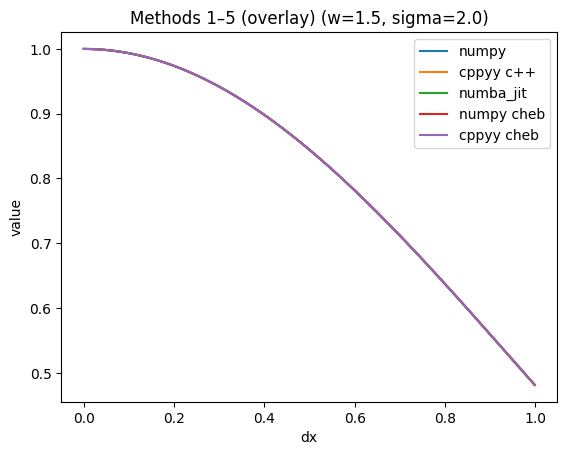

In [19]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))
y4 = [np_cheb(x) for x in dx_plot]
curves.append((y4, "numpy cheb"))
y5 = [kaiser_bessel_cheb(x) for x in dx_plot]
curves.append((y5, "cppyy cheb"))

plot_overlay(curves, title="Methods 1–5 (overlay)")

In [20]:
results.append(benchmark_func(lambda x: kaiser_bessel_cheb(x), "cppyy cheb", dx_bench))


df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,9.363887,0.010679,80855.205152,1.000000
1,cppyy c++,100000,0.081539,1.226400,80855.205152,114.838703
2,numba_jit,100000,0.100530,0.994723,80855.205152,93.144750
3,numpy cheb,100000,0.446331,0.224049,80855.205152,20.979681
4,cppyy cheb,100000,0.014768,6.771399,80855.205152,634.066082


## Method 6: Adaptive Chebyshev tree via Baobzi
Uses a FI developed library `baobzi` to fit the function to multiple Che

In [21]:
def kaiser_bessel_wrapper(dx):
    return kaiser_bessel_numpy(dx[0])

input_dim = 1
order = 8
center = np.array([0.5])
half_length = np.array([0.5])
tol = 1e-12

kaiser_bessel_baobzi_vectorized = Baobzi(kaiser_bessel_wrapper, input_dim, order, center, half_length, tol)

# Baobzi is intended for vectors, so coax it to scalar eval
def kaiser_bessel_baobzi(dx):
    return kaiser_bessel_baobzi_vectorized(np.array([dx]))

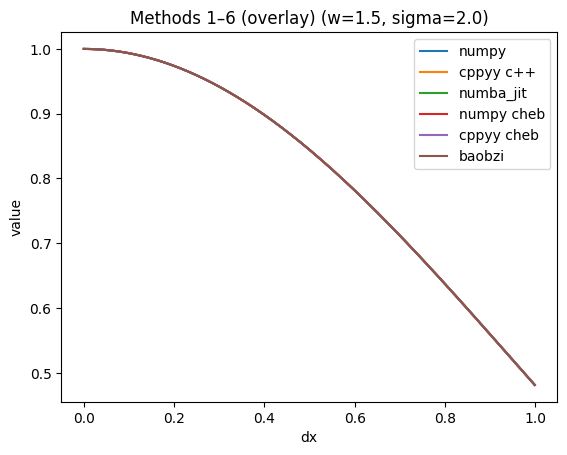

In [22]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))
y4 = [np_cheb(x) for x in dx_plot]
curves.append((y4, "numpy cheb"))
y5 = [kaiser_bessel_cheb(x) for x in dx_plot]
curves.append((y5, "cppyy cheb"))
y6 = [kaiser_bessel_baobzi(x) for x in dx_plot]
curves.append((y6, "baobzi"))

plot_overlay(curves, title="Methods 1–6 (overlay)")

## Benchmark: Methods 1–6 with speedup

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,9.363887,0.010679,80855.205152,1.000000
1,cppyy c++,100000,0.081539,1.226400,80855.205152,114.838703
2,numba_jit,100000,0.100530,0.994723,80855.205152,93.144750
3,numpy cheb,100000,0.446331,0.224049,80855.205152,20.979681
4,cppyy cheb,100000,0.014768,6.771399,80855.205152,634.066082
5,baobzi,100000,0.174461,0.573194,80855.205152,53.673259


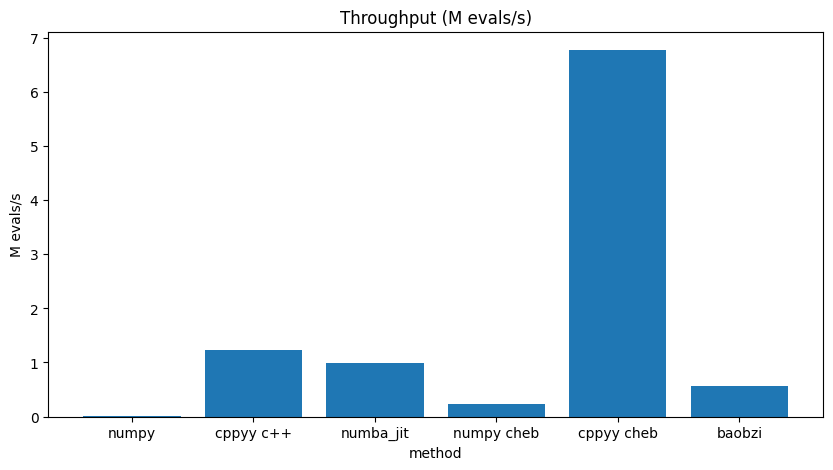

In [23]:
results.append(benchmark_func(lambda x: kaiser_bessel_baobzi(x), "baobzi", dx_bench))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
# Reorder rows to the requested method order if present
order = ["numpy", "cppyy c++", "numba_jit", "numpy cheb", "cppyy cheb"]
df["order_idx"] = df["method"].apply(lambda m: order.index(m) if m in order else 999)
df = df.sort_values(["order_idx"]).drop(columns=["order_idx"]).reset_index(drop=True)
display(df)

# Optional: simple throughput bar
plt.figure(figsize=(10, 5))
plt.bar(df["method"], df["M evals/s"])
plt.title("Throughput (M evals/s)")
plt.ylabel("M evals/s")
plt.xlabel("method")
plt.show()

## Extra: vectorized interface

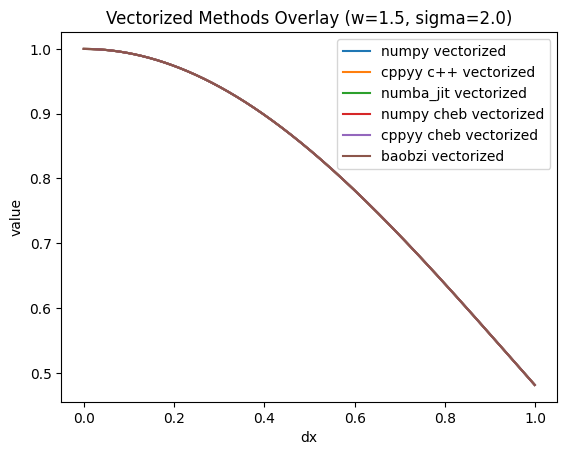

In [24]:

# Method 1: Vectorized NumPy implementation (native)
def kaiser_bessel_numpy_vec(dx):
    """
    Fully vectorized Kaiser-Bessel function using NumPy arrays.
    dx: numpy array
    Uses global parameters w and sigma.
    """
    W = w * sigma
    a = (2.0 * dx) / W
    beta = np.pi * w * (1.0 - 1.0 / (2.0 * sigma))
    inside = 1.0 - a * a
    inside = np.clip(inside, 0.0, None)
    t = np.sqrt(inside)
    return np.i0(beta * t) / np.i0(beta)


# Method 2: Vectorized C++ via cppyy (zero-copy: no input/output copying)
cppyy.cppdef(r'''
#pragma GCC optimize ("O3")
#pragma GCC target("native")

#include <cmath>
#include <cstddef>

void kaiser_bessel_vec_buf(const double* __restrict__ input, 
                            double* __restrict__ output, 
                            size_t n, 
                            double w, 
                            double sigma) {
    const double W = w * sigma;
    constexpr double pi = 3.14159265358979323846;
    const double beta = pi * w * (1.0 - 1.0 / (2.0 * sigma));
    const double beta_inv = 1.0 / std::cyl_bessel_i(0.0, beta);
    
    #pragma GCC ivdep
    for (size_t i = 0; i < n; ++i) {
        const double a = (2.0 * input[i]) / W;
        const double inside = 1.0 - a * a;
        const double t = std::sqrt(inside);
        output[i] = std::cyl_bessel_i(0.0, beta * t) * beta_inv;
    }
}
''')

def kaiser_bessel_cpp_vec(dx):
    """
    Vectorized Kaiser-Bessel function using C++ via cppyy (zero-copy).
    dx: numpy array
    Uses global parameters w and sigma.
    Zero-copy: operates directly on numpy buffer memory.
    """
    result = np.empty_like(dx)
    cppyy.gbl.kaiser_bessel_vec_buf(dx, result, len(dx), float(w), float(sigma))
    return result


# Method 3: Vectorized Numba JIT using C++ i0 from cppyy
@numba.njit
def kaiser_bessel_jit_vec(dx, w_val, sigma_val):
    """
    Vectorized Kaiser-Bessel function using Numba JIT with C++ Bessel function.
    dx: numpy array
    w_val, sigma_val: parameters passed from global values
    """
    W = w_val * sigma_val
    beta = math.pi * w_val * (1.0 - 1.0 / (2.0 * sigma_val))
    beta_i0 = cppyy.gbl.i0(beta)
    
    result = np.empty(len(dx))
    for i in numba.prange(len(dx)):
        a = (2.0 * dx[i]) / W
        inside = 1.0 - a * a
        if inside < 0.0:
            inside = 0.0
        t = math.sqrt(inside)
        result[i] = cppyy.gbl.i0(beta * t) / beta_i0
    
    return result


# Method 4: Vectorized NumPy Chebyshev (already supports arrays natively)
def kaiser_bessel_numpy_cheb_vec(dx):
    """
    Vectorized Kaiser-Bessel using NumPy Chebyshev polynomial.
    dx: numpy array
    The Chebyshev object already supports vectorized evaluation.
    """
    return np_cheb(dx)


# Method 5: Vectorized C++ Chebyshev (zero-copy: no input/output copying)
def kaiser_bessel_cheb_vec(dx):
    """
    Vectorized Kaiser-Bessel using C++ Chebyshev approximation.
    dx: numpy array
    Uses global parameters w and sigma via the fitted approximant.
    Zero-copy: operates directly on numpy buffer memory.
    """
    result = np.empty_like(dx)
    # Pass numpy array buffers directly to C++ - no copying!
    kaiser_bessel_cheb_cpp.eval_vec_buf(dx, result, len(dx))
    return result


# Method 6: Vectorized Baobzi (already supports arrays natively)
def kaiser_bessel_baobzi_vec(dx):
    """
    Vectorized Kaiser-Bessel using Baobzi.
    dx: numpy array
    Baobzi natively supports vectorized input.
    """
    # Baobzi expects input as (n, dim) array
    dx_2d = dx.reshape(-1, 1)
    return kaiser_bessel_baobzi_vectorized(dx_2d)


# Warm up JIT compilation for vectorized version
def _numba_vec_warmup():
    _ = kaiser_bessel_jit_vec(np.array([0.0, 0.5, 1.0]), w, sigma)

_numba_vec_warmup()

# Evaluate all methods on dx_plot (vectorized)
y1v = kaiser_bessel_numpy_vec(dx_plot)
y2v = kaiser_bessel_cpp_vec(dx_plot)
y3v = kaiser_bessel_jit_vec(dx_plot, w, sigma)
y4v = kaiser_bessel_numpy_cheb_vec(dx_plot)
y5v = kaiser_bessel_cheb_vec(dx_plot)
y6v = kaiser_bessel_baobzi_vec(dx_plot)

curves_vec = [
    (y1v, "numpy vectorized"),
    (y2v, "cppyy c++ vectorized"),
    (y3v, "numba_jit vectorized"),
    (y4v, "numpy cheb vectorized"),
    (y5v, "cppyy cheb vectorized"),
    (y6v, "baobzi vectorized")
]

plot_overlay(curves_vec, title="Vectorized Methods Overlay")

## Benchmark: Vectorized Methods

Benchmarking vectorized implementations with array operations.

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy vectorized,10000000,1.164003,8.591045,8.089212e+06,1.000000
1,cppyy c++ vectorized,10000000,2.628754,3.804084,8.089212e+06,0.442796
2,numba_jit vectorized,10000000,2.575842,3.882225,8.089212e+06,0.451892
3,numpy cheb vectorized,10000000,0.746765,13.391089,8.089212e+06,1.558726
4,cppyy cheb vectorized,10000000,0.070847,141.149458,8.089212e+06,16.429835
5,baobzi vectorized,10000000,0.087041,114.888449,8.089212e+06,13.373047


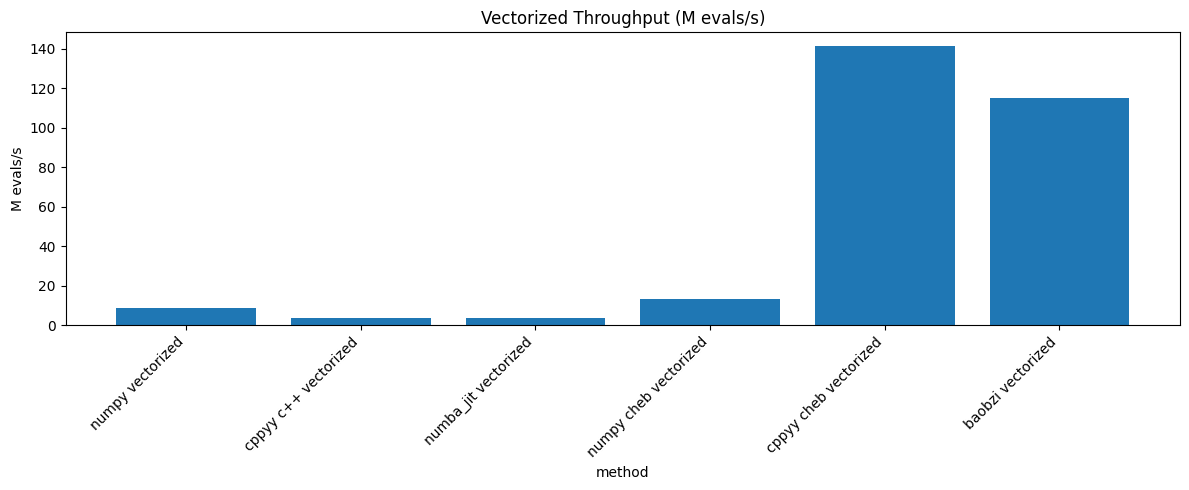

In [25]:
dx_bench = rng.uniform(a, b, size=100*N)  # fixed samples for fair comparisons
# Benchmark vectorized methods
def benchmark_func_vec(func, name, elems, warmup=None):
    """
    func: callable (vectorized function)
    name: str
    elems: numpy array
    warmup: optional callable to warm up JITs (e.g., numba) before timing.
    """
    if warmup is not None:
        warmup()

    t0 = time.perf_counter()
    y = func(elems)
    t1 = time.perf_counter()

    N = len(elems)
    total_time = t1 - t0
    return {
        "method": name,
        "N": N,
        "seconds": total_time,
        "M evals/s": (N / total_time) / 1e6,"""  """
        "checksum": float(np.sum(y))
    }

results_vec = []
results_vec.append(benchmark_func_vec(lambda x: kaiser_bessel_numpy_vec(x), 
                                      "numpy vectorized", dx_bench))
results_vec.append(benchmark_func_vec(lambda x: kaiser_bessel_cpp_vec(x), 
                                      "cppyy c++ vectorized", dx_bench))
results_vec.append(benchmark_func_vec(lambda x: kaiser_bessel_jit_vec(x, w, sigma), 
                                      "numba_jit vectorized", dx_bench, warmup=_numba_vec_warmup))
results_vec.append(benchmark_func_vec(lambda x: kaiser_bessel_numpy_cheb_vec(x), 
                                      "numpy cheb vectorized", dx_bench))
results_vec.append(benchmark_func_vec(lambda x: kaiser_bessel_cheb_vec(x), 
                                      "cppyy cheb vectorized", dx_bench))
results_vec.append(benchmark_func_vec(lambda x: kaiser_bessel_baobzi_vec(x), 
                                      "baobzi vectorized", dx_bench))

df_vec = pd.DataFrame(results_vec)
df_vec = add_relative_speedup(df_vec, baseline="numpy vectorized")

# Reorder rows
order_vec = ["numpy vectorized", "cppyy c++ vectorized", "numba_jit vectorized", 
             "numpy cheb vectorized", "cppyy cheb vectorized", "baobzi vectorized"]
df_vec["order_idx"] = df_vec["method"].apply(lambda m: order_vec.index(m) if m in order_vec else 999)
df_vec = df_vec.sort_values(["order_idx"]).drop(columns=["order_idx"]).reset_index(drop=True)
display(df_vec)

# Throughput comparison bar chart
plt.figure(figsize=(12, 5))
plt.bar(df_vec["method"], df_vec["M evals/s"])
plt.title("Vectorized Throughput (M evals/s)")
plt.ylabel("M evals/s")
plt.xlabel("method")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()